In [1]:
print("hello world")

hello world


Training a CNN for binary classification (MCMLC) on 512*512*3 retinal images to detect desease risk. 

In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset
from classes.CNNBinaryClassif import CNNBinaryClassif

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading


In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='binary'
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

## 3. Model definition

In [6]:
NUMBER_OF_LABELS = 1
model = CNNBinaryClassif().to(device)

## 4. Loss definition

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([401 / 1519], device=device))  
# Adjust pos_weight as needed for class imbalance according to the EDA results

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler() # Use mixed precision for faster training and reduced memory usage

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc,
        get_device_properties=True, memory_allocated=True, memory_reserved=True
    )

    scheduler.step(test_loss)
    
    # Early stopping
    if epoch > 5:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)
    torch.cuda.empty_cache()
    print("="*70)

Epoch number: 0


100%|██████████| 15/15 [00:47<00:00,  3.19s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 6.3842 | Train Accuracy: 0.7026 | Train F1-score: 0.8170 | Train ROC-AUC: 0.5243 |
| Test Loss:  0.6013 | Test Accuracy:  0.6797 | Test F1-score:  0.7689 | Test ROC-AUC:  0.7760 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.56 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 15/15 [00:49<00:00,  3.32s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.7783 | Train Accuracy: 0.7083 | Train F1-score: 0.8222 | Train ROC-AUC: 0.6055 |
| Test Loss:  0.4826 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.7864 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 15/15 [00:47<00:00,  3.18s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5703 | Train Accuracy: 0.7589 | Train F1-score: 0.8597 | Train ROC-AUC: 0.6448 |
| Test Loss:  0.4719 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.7508 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 15/15 [00:53<00:00,  3.59s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5269 | Train Accuracy: 0.7865 | Train F1-score: 0.8794 | Train ROC-AUC: 0.6414 |
| Test Loss:  0.5058 | Test Accuracy:  0.7922 | Test F1-score:  0.8836 | Test ROC-AUC:  0.8304 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5056 | Train Accuracy: 0.7891 | Train F1-score: 0.8813 | Train ROC-AUC: 0.6761 |
| Test Loss:  0.4516 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8007 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 15/15 [00:55<00:00,  3.71s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5141 | Train Accuracy: 0.7885 | Train F1-score: 0.8810 | Train ROC-AUC: 0.6526 |
| Test Loss:  0.4753 | Test Accuracy:  0.7906 | Test F1-score:  0.8831 | Test ROC-AUC:  0.8249 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4966 | Train Accuracy: 0.7911 | Train F1-score: 0.8823 | Train ROC-AUC: 0.6680 |
| Test Loss:  0.4641 | Test Accuracy:  0.7906 | Test F1-score:  0.8829 | Test ROC-AUC:  0.8369 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 15/15 [00:57<00:00,  3.81s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5028 | Train Accuracy: 0.7885 | Train F1-score: 0.8814 | Train ROC-AUC: 0.6690 |
| Test Loss:  0.4941 | Test Accuracy:  0.7937 | Test F1-score:  0.8844 | Test ROC-AUC:  0.8290 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 15/15 [00:57<00:00,  3.85s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4948 | Train Accuracy: 0.7891 | Train F1-score: 0.8815 | Train ROC-AUC: 0.6709 |
| Test Loss:  0.4386 | Test Accuracy:  0.7891 | Test F1-score:  0.8819 | Test ROC-AUC:  0.8376 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4856 | Train Accuracy: 0.7984 | Train F1-score: 0.8851 | Train ROC-AUC: 0.6912 |
| Test Loss:  0.4539 | Test Accuracy:  0.8469 | Test F1-score:  0.9107 | Test ROC-AUC:  0.8482 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 15/15 [00:58<00:00,  3.88s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4700 | Train Accuracy: 0.8026 | Train F1-score: 0.8886 | Train ROC-AUC: 0.7178 |
| Test Loss:  0.4698 | Test Accuracy:  0.8281 | Test F1-score:  0.9011 | Test ROC-AUC:  0.8401 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 15/15 [00:59<00:00,  3.98s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4713 | Train Accuracy: 0.7969 | Train F1-score: 0.8852 | Train ROC-AUC: 0.7178 |
| Test Loss:  0.4388 | Test Accuracy:  0.8531 | Test F1-score:  0.9138 | Test ROC-AUC:  0.8487 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 15/15 [00:56<00:00,  3.80s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4663 | Train Accuracy: 0.8042 | Train F1-score: 0.8884 | Train ROC-AUC: 0.7228 |
| Test Loss:  0.4445 | Test Accuracy:  0.8578 | Test F1-score:  0.9152 | Test ROC-AUC:  0.8496 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 15/15 [00:56<00:00,  3.77s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4486 | Train Accuracy: 0.8068 | Train F1-score: 0.8899 | Train ROC-AUC: 0.7476 |
| Test Loss:  0.4353 | Test Accuracy:  0.8578 | Test F1-score:  0.9155 | Test ROC-AUC:  0.8529 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 15/15 [01:03<00:00,  4.23s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4608 | Train Accuracy: 0.8010 | Train F1-score: 0.8868 | Train ROC-AUC: 0.7305 |
| Test Loss:  0.4388 | Test Accuracy:  0.8641 | Test F1-score:  0.9192 | Test ROC-AUC:  0.8588 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 15/15 [00:57<00:00,  3.82s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4512 | Train Accuracy: 0.8089 | Train F1-score: 0.8913 | Train ROC-AUC: 0.7419 |
| Test Loss:  0.4268 | Test Accuracy:  0.8625 | Test F1-score:  0.9182 | Test ROC-AUC:  0.8551 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 15/15 [00:58<00:00,  3.90s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4452 | Train Accuracy: 0.8135 | Train F1-score: 0.8938 | Train ROC-AUC: 0.7439 |
| Test Loss:  0.4294 | Test Accuracy:  0.8672 | Test F1-score:  0.9200 | Test ROC-AUC:  0.8542 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 15/15 [01:03<00:00,  4.23s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4475 | Train Accuracy: 0.8052 | Train F1-score: 0.8886 | Train ROC-AUC: 0.7492 |
| Test Loss:  0.4194 | Test Accuracy:  0.8672 | Test F1-score:  0.9202 | Test ROC-AUC:  0.8575 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 15/15 [00:55<00:00,  3.73s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4452 | Train Accuracy: 0.8083 | Train F1-score: 0.8906 | Train ROC-AUC: 0.7483 |
| Test Loss:  0.4236 | Test Accuracy:  0.8719 | Test F1-score:  0.9228 | Test ROC-AUC:  0.8554 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 15/15 [00:57<00:00,  3.84s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4519 | Train Accuracy: 0.8036 | Train F1-score: 0.8886 | Train ROC-AUC: 0.7360 |
| Test Loss:  0.4285 | Test Accuracy:  0.8672 | Test F1-score:  0.9205 | Test ROC-AUC:  0.8538 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 15/15 [00:57<00:00,  3.86s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4409 | Train Accuracy: 0.8068 | Train F1-score: 0.8904 | Train ROC-AUC: 0.7578 |
| Test Loss:  0.4253 | Test Accuracy:  0.8719 | Test F1-score:  0.9229 | Test ROC-AUC:  0.8624 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 15/15 [00:57<00:00,  3.83s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4369 | Train Accuracy: 0.7990 | Train F1-score: 0.8855 | Train ROC-AUC: 0.7679 |
| Test Loss:  0.4192 | Test Accuracy:  0.8703 | Test F1-score:  0.9221 | Test ROC-AUC:  0.8645 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 22


100%|██████████| 15/15 [00:56<00:00,  3.79s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.4397 | Train Accuracy: 0.8068 | Train F1-score: 0.8900 | Train ROC-AUC: 0.7598 |
| Test Loss:  0.4203 | Test Accuracy:  0.8719 | Test F1-score:  0.9229 | Test ROC-AUC:  0.8663 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.52 Go          | cached: 3.76 Go       |
------------------------------------------------------------------------------------------------
Early stopping à l'epoch 22


In [10]:
torch.save(model.state_dict(), '../Models/model_simple_cnn_bc_retina.pth')

In [11]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_simple_cnn_bc_retina.csv', index=False)

## 6. Evolution of the training

In [12]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_simple_cnn_bc_retina.csv')

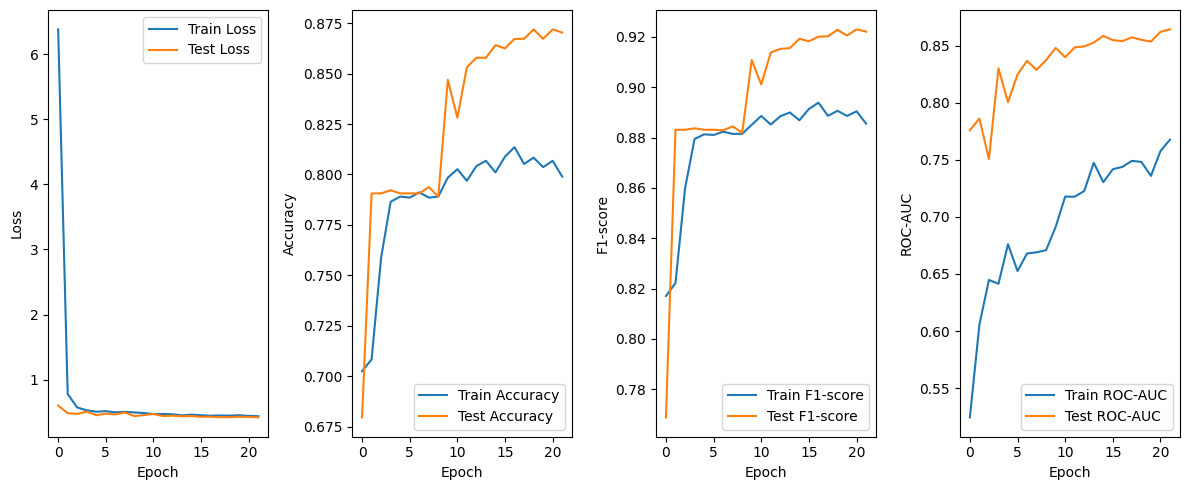

In [13]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_bc_retina_zoomed.png',
    title='Training Evolution Zoomed - Simple CNN Binary Classification',
    zoomed=True
)

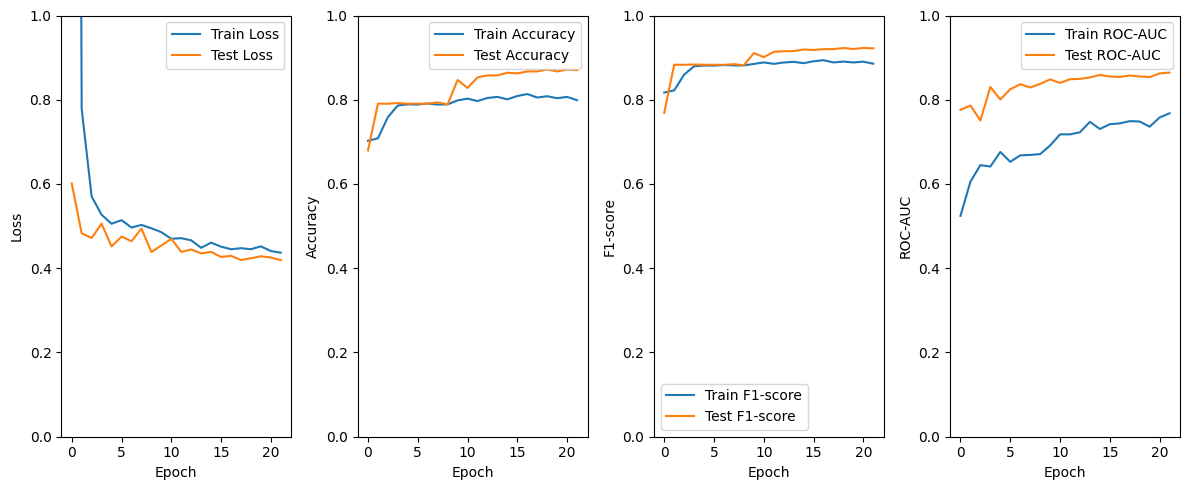

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_bc_retina.png',
    title='Training Evolution - Simple CNN Binary Classification',
    zoomed=False
)

## 7. Model evaluation

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBinaryClassif().to(device)
model.load_state_dict(torch.load('../Models/model_simple_cnn_bc_retina.pth', weights_only=True))
criterion = nn.BCEWithLogitsLoss() 

In [17]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [18]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.4598 | Validation Accuracy: 0.8172 | Validation F1-score: 0.8941 | Validation ROC-AUC: 0.7871
